In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta
from Vulnerabilities_sorter import sorter
from reportlab.platypus import SimpleDocTemplate, Image, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
import pandas as pd
import os

In [4]:
data = pd.read_csv('../../Database/Vulnerabilities/DataVulnerabilities.csv', sep=";")
data = data.replace(',', '.', regex=True)
del data[data.columns[0]]
print(data)

    AVA1  AVA2  AVA3  AVA4   CPB CPB.1 CPB.2  EBO    EFF EFF.1  ... INO.2  \
0      0     0     0     0     0     0     0    0      0     0  ...     0   
1  0.001  0.03  0.03  0.03  0.01  0.01  0.01    0  0.001  0.01  ...   0.1   
2    0.2   0.4   0.5     1   0.1   0.3   0.8    0    0.3   0.3  ...   0.3   
3    0.6   0.8     1     1   0.3   0.6   0.9    1    0.8   0.8  ...   0.6   
4      1     1     1     1     1     1     1    1      1     1  ...     1   

  INOD INOD.1 INOD.2    LAC LAC.1  LTO LTO.1 LTO.2 LTO.3  
0    0      0      0      0     0    0     0     0     0  
1  0.1    0.1    0.1  0.001   0.1  0.1   0.1   0.1   0.1  
2  0.3    0.3    0.8    0.2   0.3  0.3   0.3   0.5   0.8  
3  0.5    0.8      1    0.2   0.4  0.6     1     1     1  
4    1      1      1      1     1    1     1     1     1  

[5 rows x 27 columns]


In [6]:
data = sorter('../../Database/Vulnerabilities/DataVulnerabilities2.csv')
print(data)

class_fit   AA   AB   AC   AD   AE    AF    AG    AH   AI   AJ  ...    FF  \
V_0          0    0    0    0    0     0     0     0    0    0  ...     0   
V_L        0.1  0.1  0.1  0.1  0.1   0.1  0.05  0.05  0.1  0.1  ...     0   
V_M        0.3  0.3  0.5  0.5  0.8   0.3  0.25   0.3  0.6  0.3  ...  0.05   
V_H        0.6    1    1  0.9    1  0.75   0.5   0.6    1  0.7  ...   0.3   
V_max        1    1    1    1    1     1     1     1    1    1  ...     1   

class_fit    FG    FH    FI     FJ     FK     FL     FM     FN     FO  
V_0           0     0     0      0      0      0      0      0      0  
V_L        0.05     0  0.05  0.005  0.005  0.005  0.005  0.005  0.001  
V_M         0.1  0.03   0.1    0.3    0.2    0.4    0.2    0.1    0.2  
V_H         0.3   0.1     1      1    0.3      1    0.6    0.4    0.6  
V_max         1     1     1      1      1      1      1      1      1  

[5 rows x 145 columns]


In [23]:
def fit_beta_cdf(xs, Fs):
    xs = np.asarray(xs, dtype=float)
    Fs = np.asarray(Fs, dtype=float)

    xmin, xmax = np.min(xs), np.max(xs)
    x_scaled = (xs - xmin) / (xmax - xmin)

    def loss(params):
        a, b = params
        if a <= 0 or b <= 0:
            return 1.e6
        modelF = beta.cdf(x_scaled, a, b)
        return np.mean((modelF - Fs)**2)
    #res = minimize(loss, x0=[2.0, 2.0], bounds=[(1e-3, None), (1e-3, None)])
    res = minimize(loss, x0=[1.0,1.0], bounds=[(1e-3, None), (1e-3, None)])
    a, b = res.x

    return a, b, xmin, (xmax - xmin)

In [6]:
params_beta = np.zeros(shape=[data.shape[1], 4])
classes = np.arange(0,5)
titles = []
print(data.columns)
for idx, c in enumerate(data.columns):
    titles.append(c)
    cumulative = np.array(pd.to_numeric(data[c]))
    params_beta[idx, 0], params_beta[idx, 1], params_beta[idx, 2], params_beta[idx,3] = fit_beta_cdf(classes,cumulative)

Index(['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ',
       ...
       'FF', 'FG', 'FH', 'FI', 'FJ', 'FK', 'FL', 'FM', 'FN', 'FO'],
      dtype='object', name='class_fit', length=145)


In [7]:
plt.rcParams.update({'font.size': 18})
for idx, c in enumerate(data.columns):
    plt.figure()
    plt.title(c)
    plt.plot(np.array(pd.to_numeric(data[c])), 'x')
    plt.plot(np.linspace(0,4), stats.beta.cdf(np.linspace(0,4), params_beta[idx,0], params_beta[idx,1], loc=params_beta[idx, 2], scale=params_beta[idx, 3]), label=f'a={np.round(params_beta[idx,0],1)}, b={np.round(params_beta[idx,1],1)}')
    plt.ylabel('Cumulative')
    plt.xlabel('Classes')
    plt.grid('on')
    plt.legend()
    plt.savefig("../Plots/Vulnerabilities/"+c+".png", bbox_inches='tight')
    plt.close()
    

In [8]:
arr_dict = {col: params_beta[idx, :] for idx, col in enumerate(data.columns)}
df = pd.DataFrame(arr_dict)
df.insert(0, 'parameters', ["alpha", "beta", "xmin", "xmax"])
df.to_csv("beta_fits.csv", index=False, sep=";") 

In [9]:
legends = pd.read_csv('../Database/Vulnerabilities/VulneLegend.csv', sep=";")

In [11]:
def make_caption(filename):
    indices = legends.index[legends.iloc[:, 6] == filename].tolist()
    caption = ""
    for indice in indices:
        caption += legends[legends.columns[7]][indice]+', '
    caption = caption[:-2]
    caption += '.'
    return caption

In [12]:
doc = SimpleDocTemplate("Beta_fits.pdf", pagesize=A4)
story = []
styles = getSampleStyleSheet()

for idx, c in enumerate(data.columns):
    path = "../Plots/Vulnerabilities/"+c+".png"
    if os.path.exists(path):

        img = Image(path, width=250, height=200)  
        story.append(img)

        para = Paragraph(make_caption(c), styles["Normal"])
        story.append(para)

        story.append(Spacer(1, 20))

doc.build(story)

In [31]:
params_beta = np.zeros(shape=[1, 4])
classes = np.array([0,2,10,20,50])
cumulative = np.array([0,0.01,0.3,0.8,1])
idx=0
params_beta[idx, 0], params_beta[idx, 1], params_beta[idx, 2], params_beta[idx,3] = fit_beta_cdf(classes,cumulative)

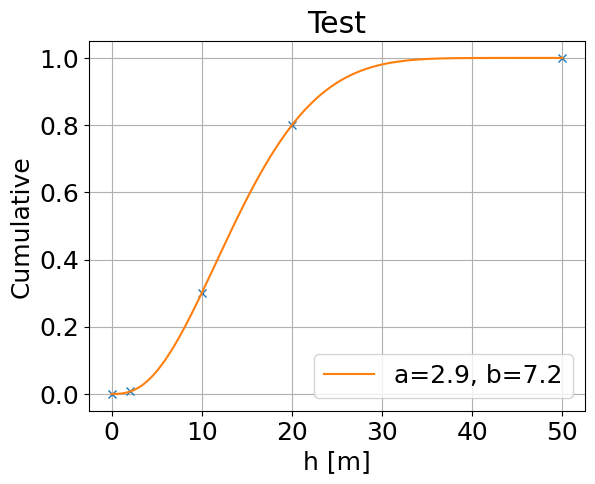

In [33]:
plt.figure()
plt.title('Test')
plt.plot(classes, cumulative, 'x')
plt.plot(np.linspace(0,50,1000), stats.beta.cdf(np.linspace(0,50,1000), params_beta[idx,0], params_beta[idx,1], loc=params_beta[idx, 2], scale=params_beta[idx, 3]), label=f'a={np.round(params_beta[idx,0],1)}, b={np.round(params_beta[idx,1],1)}')
plt.ylabel('Cumulative')
plt.xlabel('h [m]')
plt.grid('on')
plt.legend()